### First things First - Make notebook to connect with current directory

In [0]:
from google.colab import auth
auth.authenticate_user()

In [2]:
### For working on google colab

from google.colab import drive

drive.mount('/content/gdrive')
cur_dir = 'gdrive/My Drive/SRGAN Project/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
sys.path.append(cur_dir)

In [4]:
import os 
os.chdir(cur_dir)
os.getcwd()

'/content/gdrive/My Drive/SRGAN Project'

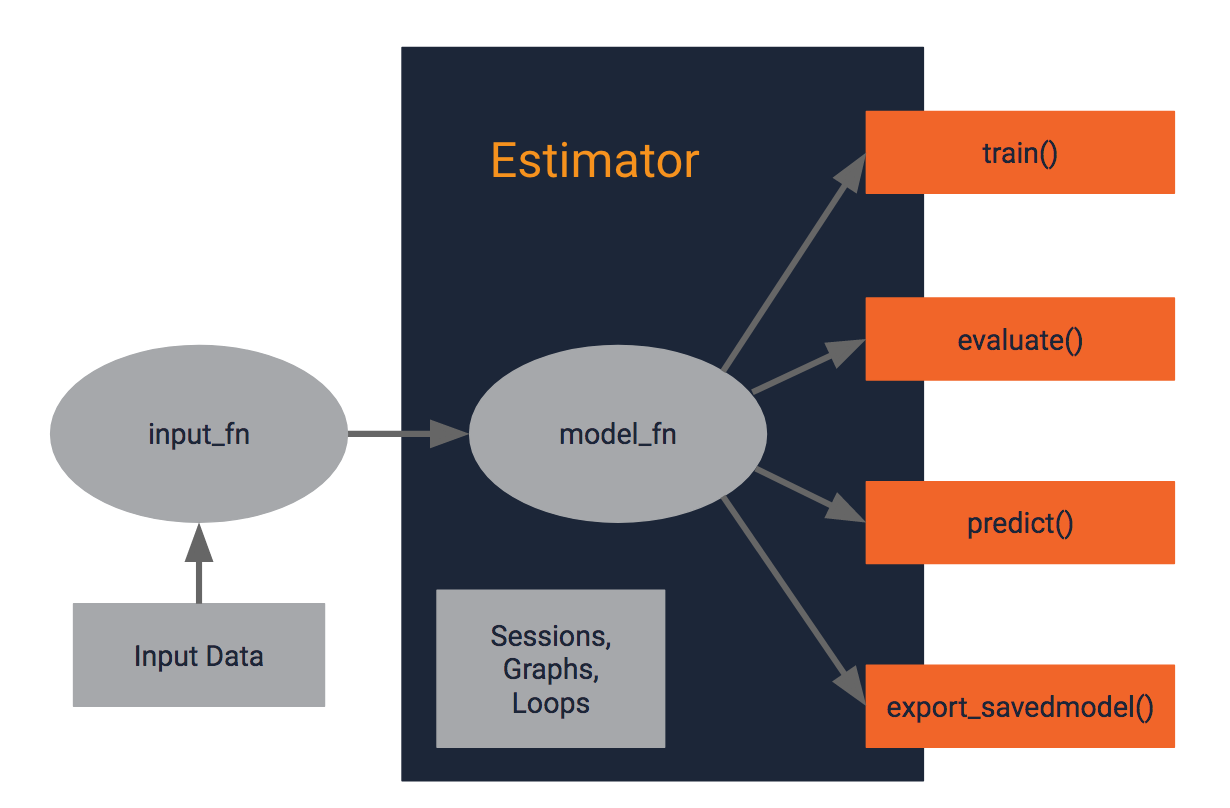

In [5]:

### Image is taken from CRAN : https://cran.r-project.org/web/packages/tfestimators/vignettes/creating_estimators.html 


from IPython.display import Image, display
display(Image(filename = 'estimator_BD.png'))

## Import Libraries

In [0]:
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning )

In [0]:
import numpy as np
np.set_printoptions(precision=4)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

In [0]:
### python 

from collections import defaultdict
import itertools

import h5py


In [0]:
### Scipy and openCV

In [0]:
### Scikit-learn packages

from sklearn.model_selection import train_test_split

In [0]:
### Installing tensorflow packages

# !pip install tensorflow==2.0
# !pip install tensorflow-gan

In [12]:
### Tensorflow packages


import tensorflow as tf
print(tf.__version__)

# --------------- Disable the tensorflow version 2.0 ----------
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

1.15.0


In [13]:
# Check that imports for the rest of the file work.
import tensorflow as tf

import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Disable noisy outputs.

In [14]:
print(tfgan.__version__)

2.0.0


In [15]:
### Keras packages

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.utils import to_categorical

from keras import layers
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization, Flatten, Conv1D , Reshape, Add, Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D , Flatten, Conv2D, ZeroPadding2D
from keras.models import Sequential, Model

from keras.optimizers import RMSprop , SGD, Adam
from keras.callbacks import ModelCheckpoint


from keras.layers import LSTM, Cropping2D, Lambda, RepeatVector, Permute, Dot, Multiply




Using TensorFlow backend.


In [0]:
import pydot


from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model



In [0]:
%load_ext autoreload
%autoreload 2
from PIL import Image
import cv2
from keras.models import load_model

# sess = tf.Session()
# from keras import backend as K
# K.set_session(sess)


# K.set_image_data_format('channels_last')

In [0]:
# tf.compat.v1.enable_eager_execution()


# from tensorflow.python.framework import ops
# tf.reset_default_graph()

### Connect keras and tensorflow sessions using following commented code
# import tensorflow as tf
# sess = tf.Session()

# from keras import backend as K
# K.set_session(sess)

# Disable noisy output.
tf.autograph.set_verbosity(0, False)

In [0]:
# tf.compat.v1.enable_eager_execution()
# tf.disable_v2_behavior()

In [0]:
from pathlib import Path
import tensorflow_datasets as tfds

In [0]:
import time
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

## Load and Preprocess data

#### Input Pipeline

In [0]:
root_path = ""
train_data_path = "data/DIV2K_train_HR/hr_images/*"
valid_data_path = "data/DIV2K_valid_HR/*"

In [0]:
tf.compat.v1.set_random_seed(10)
discriminator_img_shape = (256, 256)
original_img_shape = (2048, 1080)
generator_img_shape = (64, 64)

In [0]:
def input_fn(mode, params):

  ## check the inputs presence
  assert 'batch_size' in params
  assert 'original_img_shape' in params
  assert 'generator_img_shape' in params
  assert 'discriminator_img_shape' in params
  assert 'root_path' in params
  assert 'train_data_path' in params
  assert 'valid_data_path' in params

  ## Assign the inputs to local variables
  bs = params['batch_size']
  original_image_shape = params['original_img_shape']
  generator_img_shape = params['generator_img_shape']
  discriminator_img_shape = params['discriminator_img_shape']
  root_path = params['root_path']
  train_data_path = params['train_data_path']
  valid_data_path = params['valid_data_path']
  
  ### FLAGS 
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  # shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  shuffle = False
  just_lrimage = (mode == tf.estimator.ModeKeys.PREDICT)

  def preprocess_load(root_path, hr_image_shape = discriminator_img_shape , lr_image_shape = generator_img_shape, original_image_shape = original_img_shape , show_images = False ):


    def decode_img(img, hr_image_shape = (96, 96) , lr_image_shape = (64, 64), original_image_shape = (2048, 1080) ):

      IMG_WIDTH, IMG_HEIGHT = hr_image_shape
      # convert the compressed string to a 3D uint8 tensor
      img = tf.image.decode_jpeg(img, channels=3)

      # Use `convert_image_dtype` to convert to floats in the [0,1] range.
      img = tf.image.convert_image_dtype(img, tf.float32)
      
      # resize the image to the desired size.
      hr_img = tf.image.resize_with_crop_or_pad(img, IMG_HEIGHT , IMG_WIDTH) 

      # lr_img = tf.image.resize(img, [ int(original_img_shape[1]//4), int(original_img_shape[0]//4) ]  , method = 'bicubic' ) 
      # scipy.misc.imresize

      # lr_final_shape = np.min(int(original_img_shape[1]//4), int(original_img_shape[0]//4)) 

      lr_img = tf.image.resize(hr_img, [ int(lr_image_shape[1]), int(lr_image_shape[0]) ]  , method = 'bicubic' ) 

      return lr_img, hr_img

    def process_path(file_path, hr_image_shape = discriminator_img_shape , lr_image_shape = generator_img_shape, original_image_shape = original_img_shape ):
      # load the raw data from the file as a string
      img = tf.io.read_file(file_path)
      lr_img, hr_img = decode_img(img , hr_image_shape = hr_image_shape , lr_image_shape = lr_image_shape ,original_image_shape = original_image_shape )
      return lr_img , hr_img

    def _hr_preprocess(element):
      # Map [0, 255] to [-1, 1].
      # images = (tf.cast(element, tf.float32) - 127.5) / 127.5
      images = (tf.cast(element, tf.float32) * 2.0 ) - 1.0
      return images

    def _lr_preprocess(element):
      # Map [0, 255] to [0, 1].
      # images = (tf.cast(element, tf.float32)) / 255.0
      images = (tf.cast(element, tf.float32))
      return images

    def show_hr_image(image, label = 'high resolution image example', img_ids_hr = 1):
      # image = (tf.cast(image, tf.float32) * 127.5 ) + 127.5
      image = (tf.cast(image, tf.float32) + 1.0 ) / 2.0
      plt.figure(figsize=(10, 10))
      plt.imshow(image)
      plt.title(label)
      plt.axis('off')
      plt.savefig(root_path + "example_images/highres/img_{}.png" .format(img_ids_hr ) )


    def show_lr_image(image, label = 'low resolution image example', img_ids_lr = 1):
      # image = (tf.cast(image, tf.float32) * 255.0 ) 
      image = (tf.cast(image, tf.float32) )
      plt.figure(figsize=(10, 10))
      plt.imshow(image)
      plt.title(label)
      plt.axis('off')
      plt.savefig(root_path + "example_images/lowres/img{}.png" .format(img_ids_lr ) )


  # Start loading from the directory using above defined functions

    list_ds = tf.data.Dataset.list_files(str(root_path + train_data_path), shuffle = False)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    images_ds = list_ds.map(process_path, num_parallel_calls= AUTOTUNE)

  # Get the individual datasets
    lr_img_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img))
    hr_img_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img))

  # modify range of values
    highres_images = hr_img_ds.map(_hr_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    lowres_images = lr_img_ds.map(_lr_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if show_images == True:
      ### show high resolution images 
      for i, image1 in enumerate(highres_images.take(5)):  
        show_hr_image(image1, img_ids_hr = i+1)
      
      ### show low resolution images
      for j,image2 in enumerate(lowres_images.take(5)):  
        show_lr_image(image2, img_ids_lr= j + 1 )

    return tf.data.Dataset.zip((lowres_images, highres_images)) 

  ## load the images and preprocess them to get low and high resolution images using function "preprocess_load" implemented 
  lr_hr_images_ds = preprocess_load(root_path=root_path,hr_image_shape = discriminator_img_shape , lr_image_shape = generator_img_shape, original_image_shape = original_img_shape)

  images_ds = lr_hr_images_ds

  lowres_images_ds = (images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img))
                      .cache()
                      .repeat().batch(bs, drop_remainder = True)
                      .prefetch(tf.data.experimental.AUTOTUNE)) 

  # lowres_images = lr_hr_images_ds[0].cache().repeat()

  ## For prediction, output only the low resolution images
  if just_lrimage:
    return {"gen_input" : lowres_images_ds}

  ### Prepare the data for training the model
  highres_images = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img))
  highres_images_ds = (highres_images
                      .cache()
                      .repeat())
  highres_images_ds = (highres_images_ds.batch(bs, drop_remainder=True)
                        .prefetch(tf.data.experimental.AUTOTUNE))

  if shuffle:
    # images_ds = tf.data.Dataset.zip((lowres_images, highres_images))
    images_ds = lr_hr_images_ds.shuffle(buffer_size=10000, seed =10, reshuffle_each_iteration=True )
    
    lowres_images_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img)).cache()
    lowres_images_ds = (lowres_images_ds.batch(bs, drop_remainder = True).repeat().prefetch(tf.data.experimental.AUTOTUNE))

    highres_images_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img)).cache()
    highres_images_ds = (highres_images_ds.batch(bs, drop_remainder=True).repeat()
                        .prefetch(tf.data.experimental.AUTOTUNE))
    

  return tf.data.Dataset.zip((lowres_images_ds, highres_images_ds))

In [0]:
params = {'batch_size': 8 , 'discriminator_img_shape' : discriminator_img_shape , 'generator_img_shape' : generator_img_shape , 'original_img_shape' : original_img_shape,
          'root_path' : root_path, 'train_data_path' : train_data_path , 'valid_data_path' : valid_data_path }

In [0]:
ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)


In [27]:
ds

<DatasetV1Adapter shapes: ((8, 64, 64, 3), (8, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [0]:
lwres_images_ds = ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img))
hgres_images_ds = ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img))

In [29]:
lwres_images_ds.take(1)

<DatasetV1Adapter shapes: (8, 64, 64, 3), types: tf.float32>

In [0]:
def show_hr_image(image, label = 'high resolution image example', img_ids_hr = 1):
    # image = (tf.cast(image, tf.float32) * 127.5 ) + 127.5
    image = (tf.cast(image, tf.float32) + 1.0 ) / 2.0
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    # plt.savefig(root_path + "example_images/highres/img_{}.png" .format(img_ids_hr ) )


def show_lr_image(image, label = 'low resolution image example', img_ids_lr = 1):
    # image = (tf.cast(image, tf.float32) * 255.0 ) 
    image = (tf.cast(image, tf.float32) )
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    # plt.savefig(root_path + "example_images/lowres/img{}.png" .format(img_ids_lr ) )

In [0]:
### show high resolution images 

#    for image1 in hgres_images_ds.take(1):  
#      for i, image2 in enumerate(image1[0:10]):
#        show_hr_image(image2)
    

In [0]:
### show low resolution images 

#    for image1 in lwres_images_ds.take(1):  
#      for i, image2 in enumerate(image1[0:10]):
#        show_lr_image(image2, img_ids_lr = i+1)
    

**Download the data and sanity check the inputs.**

Low resolution images training batch 


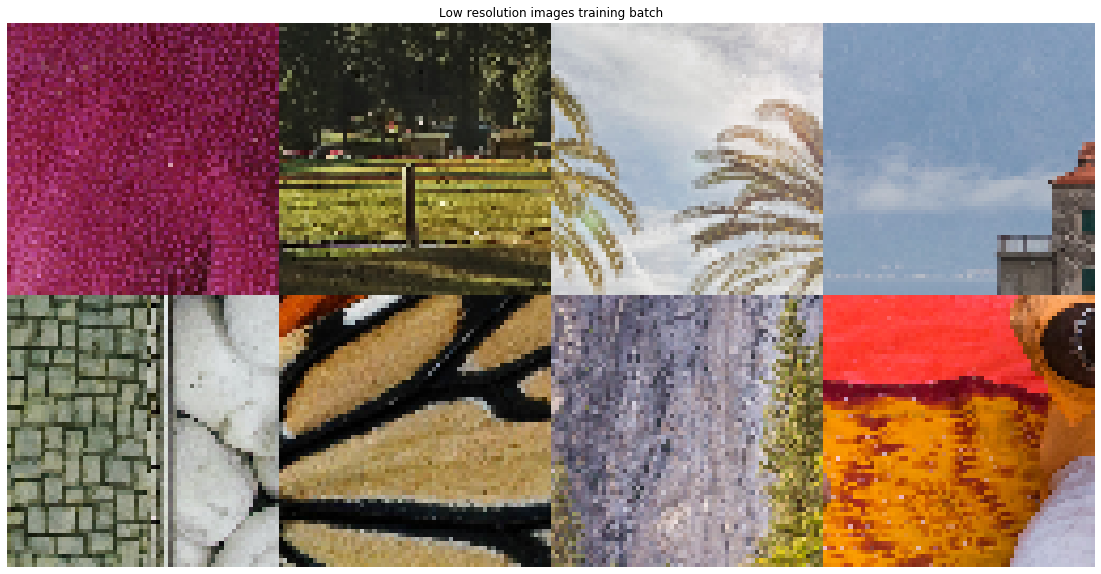

High resolution images training batch 


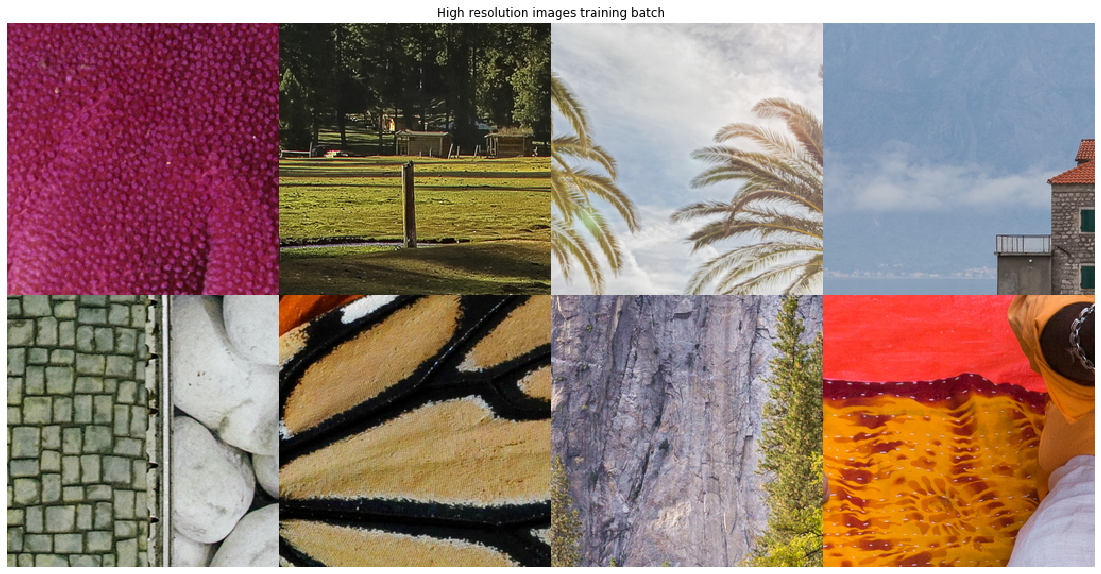

In [31]:
# import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds
# import tensorflow_gan as tfgan
# import numpy as np


ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
numpy_imgs = next(tfds.as_numpy(ds))[0]
numpy_imgs1 = next(tfds.as_numpy(ds))[1]
numpy_imgs1 = ( numpy_imgs1 + 1.0 ) / 2.0

img_grid = tfgan.eval.python_image_grid(numpy_imgs , grid_shape=(2, 4))
print('Low resolution images training batch ')
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('Low resolution images training batch')
plt.imshow(np.squeeze(img_grid))
plt.savefig(root_path + "report_images/training_samples_lowres.png")
plt.show()

print('High resolution images training batch ')
img_grid1 = tfgan.eval.python_image_grid(numpy_imgs1 , grid_shape=(2, 4))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('High resolution images training batch')
plt.imshow(np.squeeze(img_grid1))
plt.savefig(root_path + "report_images/training_samples_highres.png")
plt.show()

### Validation Input


In [0]:
def valid_input_fn(mode, params):

  ## check the inputs presence
  assert 'batch_size' in params
  assert 'original_img_shape' in params
  assert 'generator_img_shape' in params
  assert 'discriminator_img_shape' in params
  assert 'root_path' in params
  assert 'train_data_path' in params
  assert 'valid_data_path' in params

  ## Assign the inputs to local variables
  bs = params['valid_batch_size']
  original_image_shape = params['original_img_shape']
  generator_img_shape = params['generator_img_shape']
  discriminator_img_shape = params['discriminator_img_shape']
  root_path = params['root_path']
  train_data_path = params['train_data_path']
  valid_data_path = params['valid_data_path']
  
  ### FLAGS 
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  # shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  shuffle = False
  just_lrimage = (mode == tf.estimator.ModeKeys.PREDICT)

  def preprocess_load(root_path, hr_image_shape = discriminator_img_shape , lr_image_shape = generator_img_shape, original_image_shape = original_img_shape , show_images = False ):


    def decode_img(img, hr_image_shape = (96, 96) , lr_image_shape = (64, 64), original_image_shape = (2048, 1080) ):

      IMG_WIDTH, IMG_HEIGHT = hr_image_shape
      # convert the compressed string to a 3D uint8 tensor
      img = tf.image.decode_jpeg(img, channels=3)

      # Use `convert_image_dtype` to convert to floats in the [0,1] range.
      img = tf.image.convert_image_dtype(img, tf.float32)
      
      # resize the image to the desired size.
      hr_img = tf.image.resize_with_crop_or_pad(img, IMG_HEIGHT , IMG_WIDTH) 

      # lr_img = tf.image.resize(img, [ int(original_img_shape[1]//4), int(original_img_shape[0]//4) ]  , method = 'bicubic' ) 
      # scipy.misc.imresize

      # lr_final_shape = np.min(int(original_img_shape[1]//4), int(original_img_shape[0]//4)) 

      lr_img = tf.image.resize(hr_img, [ int(lr_image_shape[1]), int(lr_image_shape[0]) ]  , method = 'bicubic' ) 

      return lr_img, hr_img

    def process_path(file_path, hr_image_shape = discriminator_img_shape , lr_image_shape = generator_img_shape, original_image_shape = original_img_shape ):
      # load the raw data from the file as a string
      img = tf.io.read_file(file_path)
      lr_img, hr_img = decode_img(img , hr_image_shape = hr_image_shape , lr_image_shape = lr_image_shape ,original_image_shape = original_image_shape )
      return lr_img , hr_img

    def _hr_preprocess(element):
      # Map [0, 255] to [-1, 1].
      # images = (tf.cast(element, tf.float32) - 127.5) / 127.5
      images = (tf.cast(element, tf.float32) * 2.0 ) - 1.0
      return images

    def _lr_preprocess(element):
      # Map [0, 255] to [0, 1].
      # images = (tf.cast(element, tf.float32)) / 255.0
      images = (tf.cast(element, tf.float32))
      return images

    def show_hr_image(image, label = 'high resolution image example', img_ids_hr = 1):
      # image = (tf.cast(image, tf.float32) * 127.5 ) + 127.5
      image = (tf.cast(image, tf.float32) + 1.0 ) / 2.0
      plt.figure(figsize=(10, 10))
      plt.imshow(image)
      plt.title(label)
      plt.axis('off')
      plt.savefig(root_path + "example_images/highres/img_{}.png" .format(img_ids_hr ) )


    def show_lr_image(image, label = 'low resolution image example', img_ids_lr = 1):
      # image = (tf.cast(image, tf.float32) * 255.0 ) 
      image = (tf.cast(image, tf.float32) )
      plt.figure(figsize=(10, 10))
      plt.imshow(image)
      plt.title(label)
      plt.axis('off')
      plt.savefig(root_path + "example_images/lowres/img{}.png" .format(img_ids_lr ) )


  # Start loading from the directory using above defined functions

    list_ds = tf.data.Dataset.list_files(str(root_path + valid_data_path), shuffle = False)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    images_ds = list_ds.map(process_path, num_parallel_calls= AUTOTUNE)

  # Get the individual datasets
    lr_img_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img))
    hr_img_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img))

  # modify range of values
    highres_images = hr_img_ds.map(_hr_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    lowres_images = lr_img_ds.map(_lr_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if show_images == True:
      ### show high resolution images 
      for i, image1 in enumerate(highres_images.take(5)):  
        show_hr_image(image1, img_ids_hr = i+1)
      
      ### show low resolution images
      for j,image2 in enumerate(lowres_images.take(5)):  
        show_lr_image(image2, img_ids_lr= j + 1 )

    return tf.data.Dataset.zip((lowres_images, highres_images)) 

  ## load the images and preprocess them to get low and high resolution images using function "preprocess_load" implemented 
  lr_hr_images_ds = preprocess_load(root_path=root_path,hr_image_shape = discriminator_img_shape , lr_image_shape = generator_img_shape, original_image_shape = original_img_shape)

  images_ds = lr_hr_images_ds

  lowres_images_ds = (images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img))
                      .cache()
                      .repeat().batch(bs, drop_remainder = True)
                      .prefetch(tf.data.experimental.AUTOTUNE)) 

  # lowres_images = lr_hr_images_ds[0].cache().repeat()

  ## For prediction, output only the low resolution images
  if just_lrimage:
    return lowres_images_ds

  ### Prepare the data for training the model
  highres_images = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img))
  highres_images_ds = (highres_images
                      .cache()
                      .repeat())
  highres_images_ds = (highres_images_ds.batch(bs, drop_remainder=True)
                        .prefetch(tf.data.experimental.AUTOTUNE))

  if shuffle:
    # images_ds = tf.data.Dataset.zip((lowres_images, highres_images))
    images_ds = lr_hr_images_ds.shuffle(buffer_size=10000, seed =10, reshuffle_each_iteration=True )
    
    lowres_images_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img)).cache()
    lowres_images_ds = (lowres_images_ds.batch(bs, drop_remainder = True).repeat().prefetch(tf.data.experimental.AUTOTUNE))

    highres_images_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img)).cache()
    highres_images_ds = (highres_images_ds.batch(bs, drop_remainder=True).repeat()
                        .prefetch(tf.data.experimental.AUTOTUNE))
    

  return tf.data.Dataset.zip((lowres_images_ds, highres_images_ds))

In [0]:
params = {'batch_size': 8 , 'valid_batch_size': 10 ,'discriminator_img_shape' : discriminator_img_shape , 'generator_img_shape' : generator_img_shape , 'original_img_shape' : original_img_shape,
          'root_path' : root_path, 'train_data_path' : train_data_path , 'valid_data_path' : valid_data_path }

In [0]:
valid_ds = valid_input_fn(tf.estimator.ModeKeys.TRAIN, params)

Low resolution images training batch 


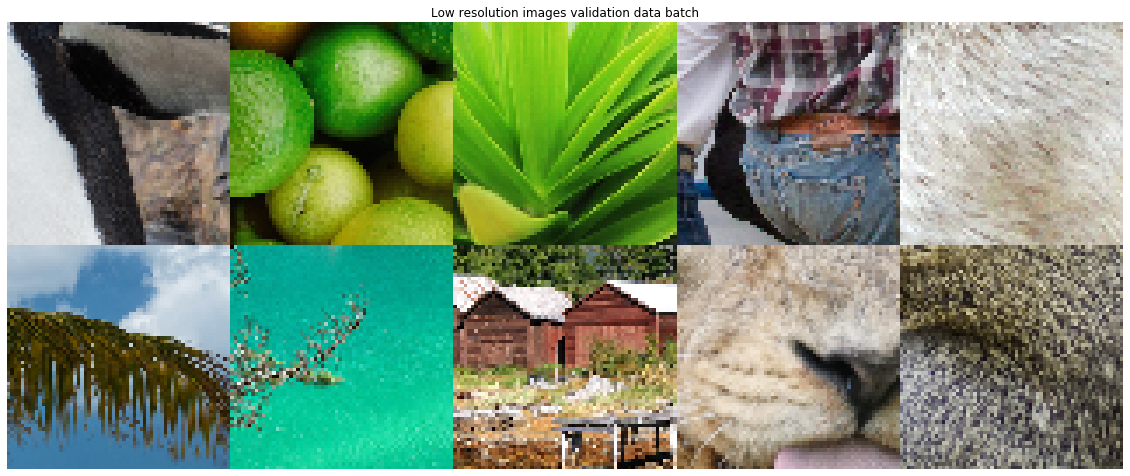

High resolution images training batch 


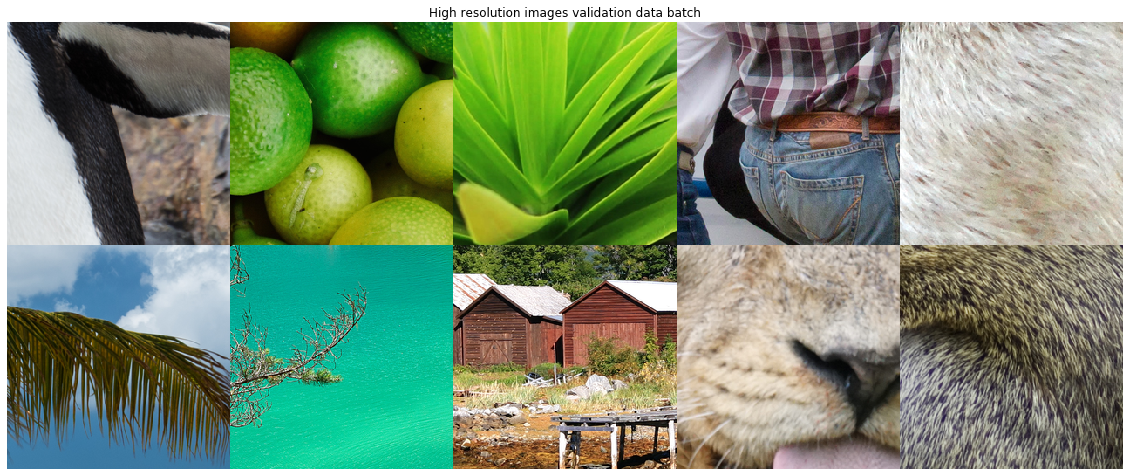

In [35]:

vaid_numpy_imgs = next(tfds.as_numpy(valid_ds))[0]
valid_numpy_imgs1 = next(tfds.as_numpy(valid_ds))[1]
valid_numpy_imgs1 = ( valid_numpy_imgs1 + 1.0 ) / 2.0

valid_img_grid = tfgan.eval.python_image_grid(vaid_numpy_imgs , grid_shape=(2, 5))
print('Low resolution images training batch ')
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('Low resolution images validation data batch')
plt.imshow(np.squeeze(valid_img_grid))
plt.savefig(root_path + "report_images/validation_samples_lowres")
plt.show()

print('High resolution images training batch ')
valid_img_grid1 = tfgan.eval.python_image_grid(valid_numpy_imgs1 , grid_shape=(2, 5))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('High resolution images validation data batch')
plt.imshow(np.squeeze(valid_img_grid1))
plt.savefig(root_path + "report_images/validation_samples_highres")
plt.show()

### Neural Network Architectures

To build our GAN we need two separate networks:

*  A generator that takes input low-resolution image and outputs generated super-resolved image
*  A discriminator that takes images (both original high resolution and super-resolution ) and outputs a probability of being real or fake

We define functions that build these networks. In the GANEstimator section below we pass the builder functions to the `GANEstimator` constructor. `GANEstimator` handles hooking the generator and discriminator together into the GAN. 

In [0]:
from srgan_model_py import generator, discriminator

In [37]:
generator

<function srgan_model_py.generator>

In [38]:
discriminator

<function srgan_model_py.discriminator>

In [39]:
model_dir = '{}'.format(
   time.strftime('gpuestimator-tfgan/%Y-%m-%d-%H-%M-%S'))
print('Using model dir: {}'.format(model_dir))

Using model dir: gpuestimator-tfgan/2020-02-24-17-42-05


In [0]:
model_dir = "gpuestimator-tfgan/saved"

### Evaluating GANs

In [0]:

content_layers = ['block5_conv4']

def vgg_layers(input_tensor):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(input_tensor= input_tensor, include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in ['block5_conv4']]

  model = tf.keras.Model([vgg.input], outputs)
  model.trainable = False
  return tf.convert_to_tensor(model.outputs, dtype = tf.float32)






#### Evaluation Metric

In [0]:



def get_eval_metric_ops_fn(gan_model):
  psnr_score = tf.image.psnr(gan_model.real_data, gan_model.generated_data, max_val=1.0)
  return {
      'psnr_score': tf.compat.v1.metrics.mean(psnr_score)
  }

#### Loss functions

In [0]:

def content_loss(hr, sr):
        # sr = preprocess_input(sr)
        # hr = preprocess_input(hr)
        sr_features = vgg_layers(sr) / 12.75
        hr_features = vgg_layers(hr) / 12.75
        meansquarederror = MeanSquaredError()
        return meansquarederror(hr_features, sr_features)

def generator_loss(sr_out):
        binaryCrossentropy = BinaryCrossentropy(from_logits=False)
        return binaryCrossentropy(tf.ones_like(sr_out), sr_out)

def discriminator_loss(gan_model):
        hr_out = tf.cast(gan_model.discriminator_real_outputs, tf.float32)
        sr_out = tf.cast(gan_model.discriminator_gen_outputs, tf.float32)
        binaryCrossentropy = BinaryCrossentropy(from_logits=False)
        hr_loss = binaryCrossentropy(tf.ones_like(hr_out), hr_out)
        sr_loss = binaryCrossentropy(tf.zeros_like(sr_out), sr_out)
        return hr_loss + sr_loss

In [0]:
def combined_loss(gan_model):
  
    # Define non-adversarial loss - for example L1
    # non_adversarial_loss = tf.losses.absolute_difference(
    #     gan_model.real_data, gan_model.generated_data)
    
    non_adversarial_loss = tfgan.losses.wasserstein_generator_loss(
        gan_model)
    # Define generator loss
    generator_loss = tfgan.losses.modified_generator_loss(
        gan_model)
    # Combine these losses - you can specify more parameters
    # Exactly one of weight_factor and gradient_ratio must be non-None
    combined_loss = non_adversarial_loss + 0.001 * generator_loss

    
    return combined_loss

In [0]:
def combined_loss2(gan_model):

    # Define non-adversarial loss - for example "VGG loss"

    ### L1 - losses (similar)
    # tfgan.losses.least_squares_generator_loss(gan_model)
    # non_adversarial_loss =  tf.keras.losses.mean_squared_error(gan_model.real_data, gan_model.generated_data) 
    non_adversarial_loss = tfgan.losses.least_squares_generator_loss(gan_model)

    # Define generator loss
    # generator_loss = generator_loss(gan_model.discriminator_gen_outputs)
    generator_loss = tfgan.losses.modified_generator_loss(gan_model)

    # Combine these losses - you can specify more parameters
    # Exactly one of weight_factor and gradient_ratio must be non-None

    combined_loss = non_adversarial_loss + 0.001 * generator_loss

    return combined_loss

In [0]:
def combined_loss3(gan_model):

    # Define non-adversarial loss - for example "VGG loss" and "MSE loss"

    non_adversarial_loss = content_loss(gan_model.real_data, gan_model.generated_data)

    non_adversarial_loss_MSE = tf.keras.losses.mean_squared_error(gan_model.real_data, gan_model.generated_data) 

    # Define generator loss
    generator_loss_value =  0.001 * generator_loss(gan_model.discriminator_gen_outputs)
    # generator_loss = tfgan.losses.modified_generator_loss(gan_model)

    # Combine these losses - you can specify more parameters
    # Exactly one of weight_factor and gradient_ratio must be non-None

    combined_loss = non_adversarial_loss + non_adversarial_loss_MSE + generator_loss_value


    return combined_loss

In [0]:

# # train_batch_size = 32 #@param
# noise_dimensions = 64 #@param
generator_lr = 0.0001 #@param
discriminator_lr = 0.0002 #@param


def get_optimizer():
  ## from out
    # adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    adam = tf.optimizers.Adam(generator_lr, 0.9)
    return adam


def gen_opt():
  gstep = tf.train.get_or_create_global_step()
  base_lr = generator_lr
  # Halve the learning rate at 1000 steps.
  lr = tf.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
  return tf.train.AdamOptimizer(lr, 0.5)

# Run Configuration
#     run_config = tf.estimator.RunConfig(
#        model_dir=model_dir, save_summary_steps=100, save_checkpoints_steps=1000)
# 

gan_estimator = tfgan.estimator.GANEstimator(model_dir = model_dir,
    generator_fn=generator,
    discriminator_fn=discriminator,
    generator_loss_fn= combined_loss3,
    discriminator_loss_fn= discriminator_loss,
    params=params,
    generator_optimizer=tf.compat.v1.train.AdamOptimizer(generator_lr, 0.9),
    discriminator_optimizer=tf.compat.v1.train.AdamOptimizer(discriminator_lr, 0.5),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn)

### Train and eval loop

In [48]:
# Disable noisy output.
tf.autograph.set_verbosity(0, False)


steps_per_eval = 100 #@param (num of images in train / batch_size = all mini batches)
max_train_steps = 800 #@param (num of epochs * (num of images in train / batch_size) )
batches_for_eval_metrics = 20 #@param  ### (Num of images / batch_size = 200 / 10)

# Used to track metrics.
steps = []
train_psnr_scores = []
valid_psnr_scores = []


cur_step = 0
start_time = time.time()
while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)

  start = time.time()
  gan_estimator.train(input_fn, max_steps=next_step)
  steps_taken = next_step - cur_step
  time_taken = time.time() - start
  print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
  print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))
  cur_step = next_step


  ########### On validation data ####################
  # Calculate some metrics on train and validation datasets.
  train_metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics, name='train_data')
  train_psnr_scores.append(train_metrics['psnr_score'])
  print('PSNR Score on train data: %.3f   ' % (train_psnr_scores[-1]))
  valid_metrics = gan_estimator.evaluate(valid_input_fn, steps=batches_for_eval_metrics, name='validation_data')
  steps.append(cur_step)
  valid_psnr_scores.append(valid_metrics['psnr_score'])
  print('PSNR Score on validation data: %.3f   ' % (valid_psnr_scores[-1]))
  
  # Vizualize some images from predictions on validation data.
  valid_iterator = gan_estimator.predict(
      valid_input_fn, hooks=[tf.train.StopAtStepHook(num_steps=21)])
  try:
    valid_imgs = np.array([next(valid_iterator) for _ in range(5)])
  except StopIteration:
    pass
  valid_tiled = tfgan.eval.python_image_grid((valid_imgs + 1.0) /2.0 , grid_shape=(1, 5))
  plt.figure(figsize=(20,5))
  plt.axis('off')
  plt.imshow(np.squeeze(valid_tiled))
  plt.savefig(root_path + "report_images/generated/valid_images_{}.png" .format(cur_step))
  plt.show()

  
  
  
### Plot the metrics vs step - train.
plt.title('PSNR score per step - Train data')
plt.plot(steps, train_psnr_scores)
plt.xlabel('train and evaluate steps')
plt.ylabel('PSNR value')
plt.savefig(root_path + "report_images/PSNR_per_step_train.png")
plt.show()

### Plot the metrics vs step - validation.
plt.title('PSNR score per step - Validation data')
plt.plot(steps, valid_psnr_scores)
plt.xlabel('train and evaluate steps')
plt.ylabel('PSNR value')
plt.savefig(root_path + "report_images/PSNR_per_step_validation.png")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

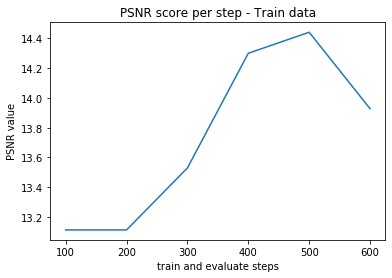

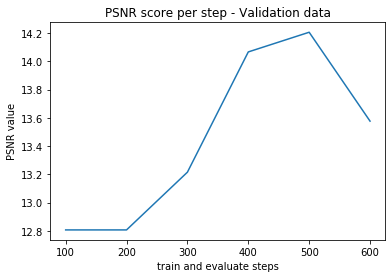

In [49]:
### Plot the metrics vs step - train.
plt.title('PSNR score per step - Train data')
plt.plot(steps, train_psnr_scores)
plt.xlabel('train and evaluate steps')
plt.ylabel('PSNR value')
plt.savefig(root_path + "report_images/PSNR_per_step_train.png")
plt.show()

### Plot the metrics vs step - validation.
plt.title('PSNR score per step - Validation data')
plt.plot(steps, valid_psnr_scores)
plt.xlabel('train and evaluate steps')
plt.ylabel('PSNR value')
plt.savefig(root_path + "report_images/PSNR_per_step_validation.png")
plt.show()

In [0]:
# gan_estimator.get_variable_names()

In [0]:
gan_estimator.latest_checkpoint()

'gpuestimator-tfgan/2020-02-22-16-51-36/model.ckpt-200'

In [0]:
!tensorboard --logdir=model_dir

TensorBoard 1.15.0 at http://3604d2dd5911:6006/ (Press CTRL+C to quit)


### Testing Phase

- Load data 

- evaluate

In [0]:
def preprocess_load_test(root_path, hr_image_shape = discriminator_img_shape , lr_image_shape = generator_img_shape, original_image_shape = original_img_shape , show_images = False ):


    def decode_img(img, hr_image_shape = (96, 96) , lr_image_shape = (64, 64), original_image_shape = (2048, 1080) ):

      IMG_WIDTH, IMG_HEIGHT = hr_image_shape
      # convert the compressed string to a 3D uint8 tensor
      img = tf.image.decode_jpeg(img, channels=3)

      # Use `convert_image_dtype` to convert to floats in the [0,1] range.
      img = tf.image.convert_image_dtype(img, tf.float32)

      return img

    def process_path(file_path, hr_image_shape = discriminator_img_shape , lr_image_shape = generator_img_shape, original_image_shape = original_img_shape ):
      # load the raw data from the file as a string
      img = tf.io.read_file(file_path)
      img_loaded = decode_img(img , hr_image_shape = hr_image_shape , lr_image_shape = lr_image_shape ,original_image_shape = original_image_shape )
      return img_loaded

    def _lr_preprocess(element):
      # Map [0, 255] to [0, 1].
      # images = (tf.cast(element, tf.float32)) / 255.0
      images = (tf.cast(element, tf.float32))
      return images

    def show_lr_image(image, label = 'low resolution image example', img_ids_lr = 1):
      # image = (tf.cast(image, tf.float32) * 255.0 ) 
      image = (tf.cast(image, tf.float32) )
      plt.figure(figsize=(10, 10))
      plt.imshow(image)
      plt.title(label)
      plt.axis('off')
      plt.savefig(root_path + "example_images/lowres/img{}.png" .format(img_ids_lr ) )


  # Start loading from the directory using above defined functions

    list_ds = tf.data.Dataset.list_files(str(root_path + test_data_path), shuffle = False)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    images_ds = list_ds.map(process_path, num_parallel_calls= AUTOTUNE)

  # Get the individual datasets
    lr_img_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img))
    hr_img_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img))

  # modify range of values
    highres_images = hr_img_ds.map(_hr_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    lowres_images = lr_img_ds.map(_lr_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if show_images == True:
      ### show high resolution images 
      for i, image1 in enumerate(highres_images.take(5)):  
        show_hr_image(image1, img_ids_hr = i+1)
      
      ### show low resolution images
      for j,image2 in enumerate(lowres_images.take(5)):  
        show_lr_image(image2, img_ids_lr= j + 1 )

    return tf.data.Dataset.zip((lowres_images, highres_images)) 

In [0]:
test_psnr_scores = []

In [0]:
########### On Test data ####################
  # Calculate some metrics on train and validation datasets.
batches_for_eval_metrics = 20
test_metrics = gan_estimator.evaluate(valid_input_fn, steps=batches_for_eval_metrics, name='test_data')
test_psnr_scores.append(test_metrics['psnr_score'])
print('PSNR Score on validation data: %.3f   ' % (test_psnr_scores[-1]))
  
  # Vizualize some images from predictions on validation data.
test_iterator = gan_estimator.predict(
      valid_input_fn, hooks=[tf.train.StopAtStepHook(num_steps=21)])
try:
    test_imgs = np.array([next(test_iterator) for _ in range(5)])
except StopIteration:
    pass
test_tiled = tfgan.eval.python_image_grid((test_imgs + 1.0) /2.0 , grid_shape=(1, 5))
  
plt.figure(figsize=(20,5))
plt.axis('off')
plt.imshow(np.squeeze(test_tiled))
plt.show()

In [0]:

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

### Save and export the model

In [0]:
serving_input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn({ 'feature' : tf.Tensor() } )

In [0]:
def serving_input_receiver_fn():
    features = {'feature' : tf.compat.v1.placeholder(tf.float32, shape=[None, None, None, 3] ) }
    # receiver_tensors = {'generator_inputs': features}
    return tf.estimator.export.ServingInputReceiver(features, features)

In [0]:
gan_estimator.export_saved_model(export_dir_base = model_dir + "/tmp_export/gan_estimator_export/", serving_input_receiver_fn= serving_input_fn)

In [0]:
!saved_model_cli show --dir 'gpuestimator-tfgan/2020-02-22-16-51-36/tmp_export/gan_estimator_export/1582494301'

The given SavedModel contains the following tag-sets:
serve


### Load the saved model